# Analyze `2 Gene` simulation coupling performance

Asses the coupling accuracy over `2-gene` simulations using the setting presented by [[FS-21]](https://www.nature.com/articles/s41467-021-25133-1).



# Preliminaries

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from utils import run_seeds, plot_trajectory, simulate_data, method_colors

import moscot as mc

In [2]:
mc.__version__

'0.2.1.dev7+g00b5161'

## Dependencies

We provide scripts which can be run on a SLURM based cluster scheduling system and output.

Running the scripts will: 
1. Produce simulated trajectories of types: "bifurcation", "convergent", "partial_convergent", and "mismatched_clusters"  using LineageOT by ([[FS-21]](https://www.nature.com/articles/s41467-021-25133-1)).
2. Compute the couplings using:
    1. LineageOT
    2. OT
    3. GW
    4. moslin
3. Evaluate coupling accuracy.

The output of this analysis is saved under `DATA_DIR`. In this notebook we use the `.csv` files `"{flow_type}_res_seeds.csv"`. 

To run the pipeline modify paths within `run.sh` to activate local environment and call:  `python3 run_sbatch.py`

## Set up paths

Define the paths for data and figures

In [3]:
sys.path.insert(
    0, "../../../"
)  # this depends on the notebook depth and must be adapted per notebook

from paths import DATA_DIR, FIG_DIR

FIG_DIR = FIG_DIR / "simulations/forrow_2gene"
DATA_DIR = DATA_DIR / "simulations/forrow_2gene"

plt.rcParams["figure.figsize"] = [1, 1]

## Set global parameters

In [4]:
flow_types = ["bifurcation", "convergent", "partial_convergent", "mismatched_clusters"]
save = True

# Visualize sample trajectories

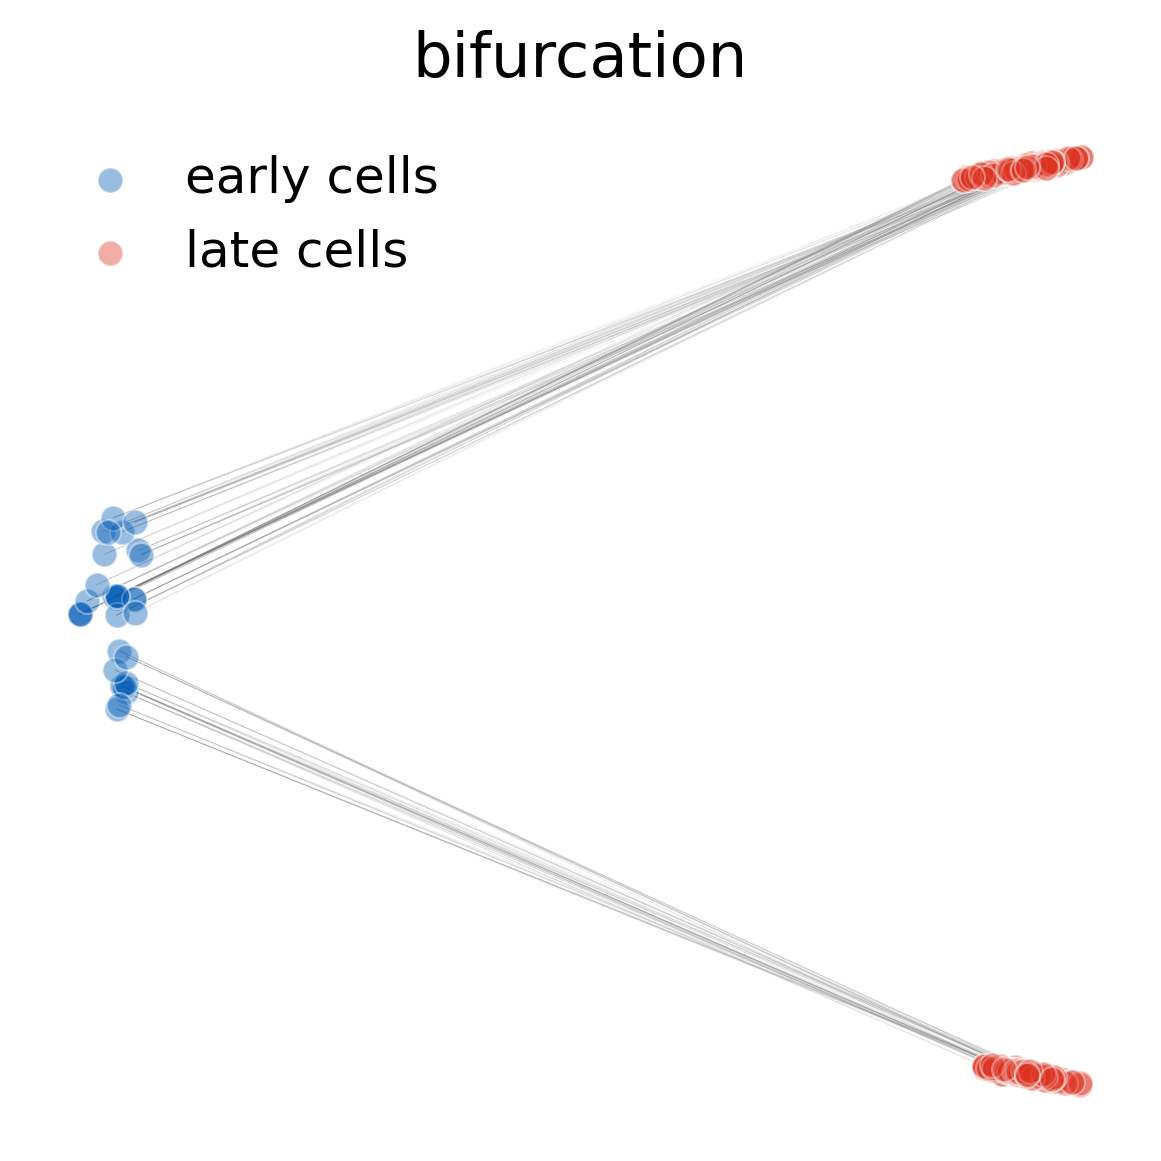

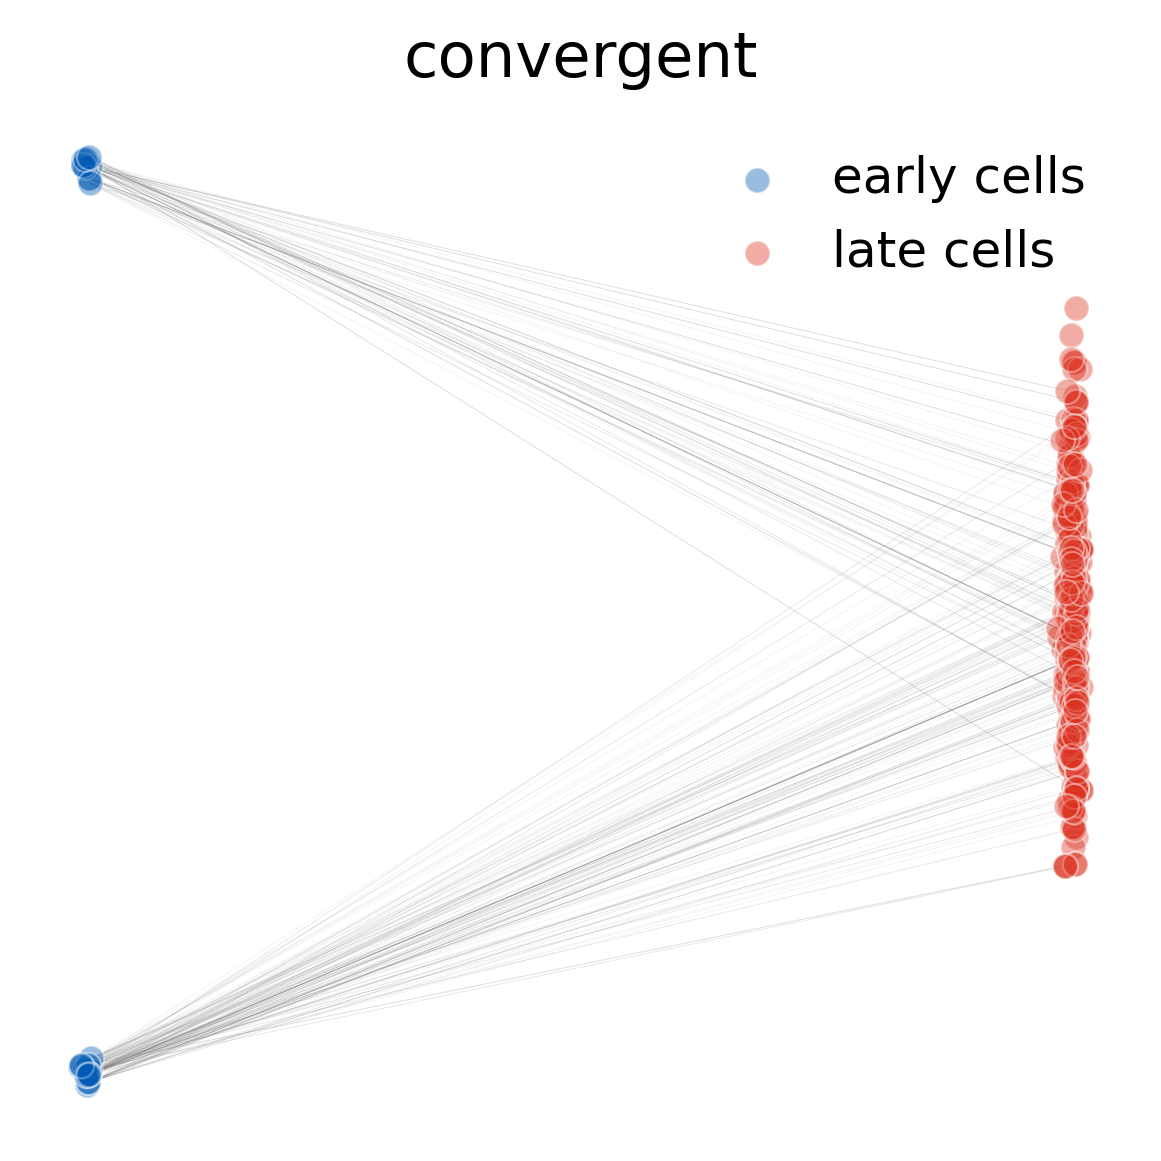

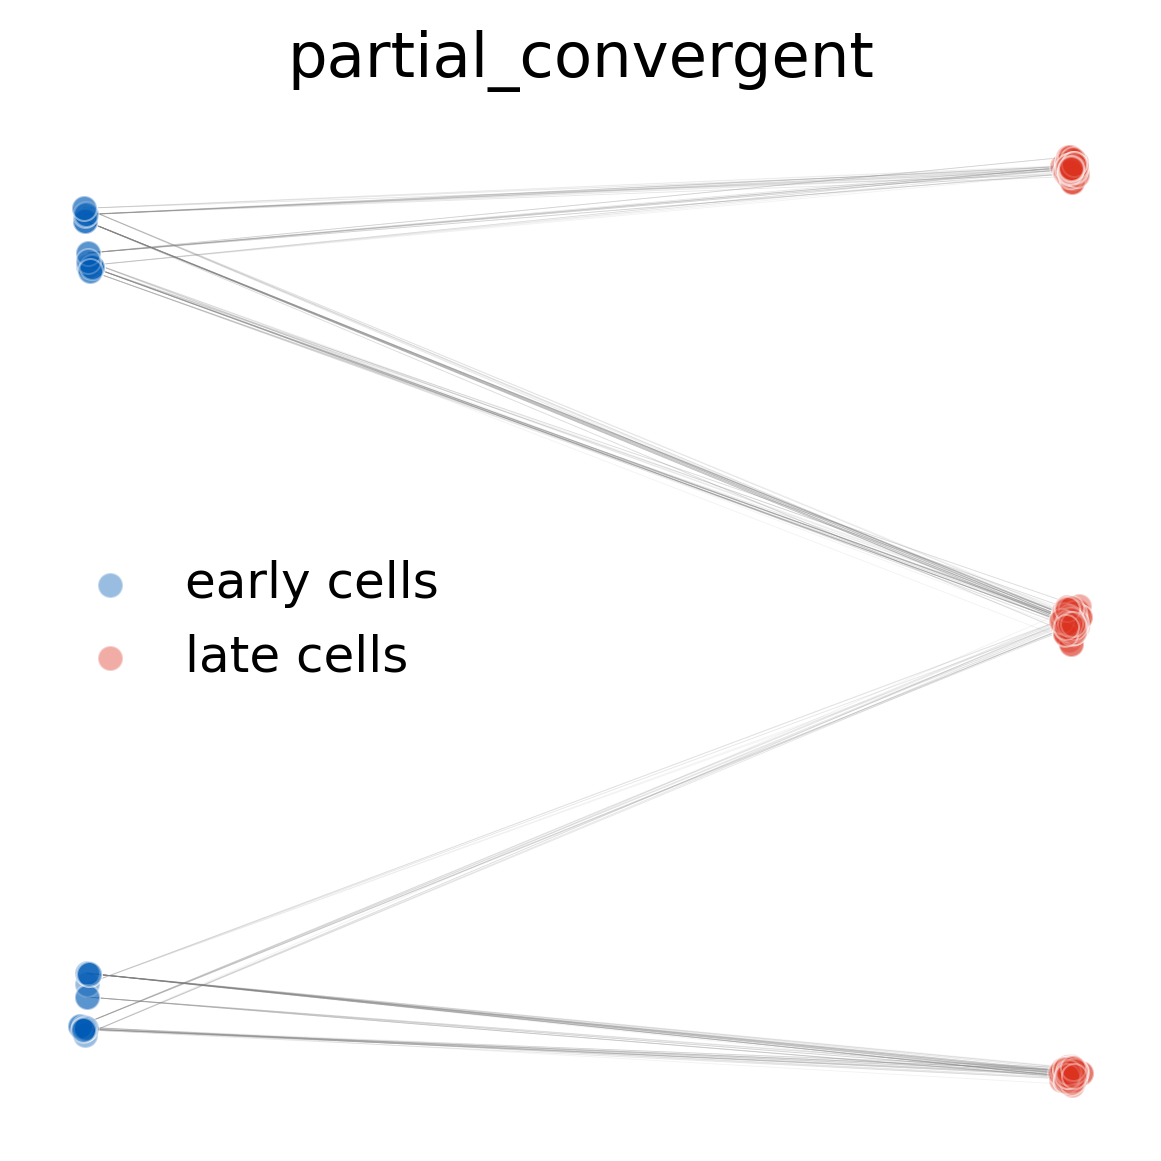

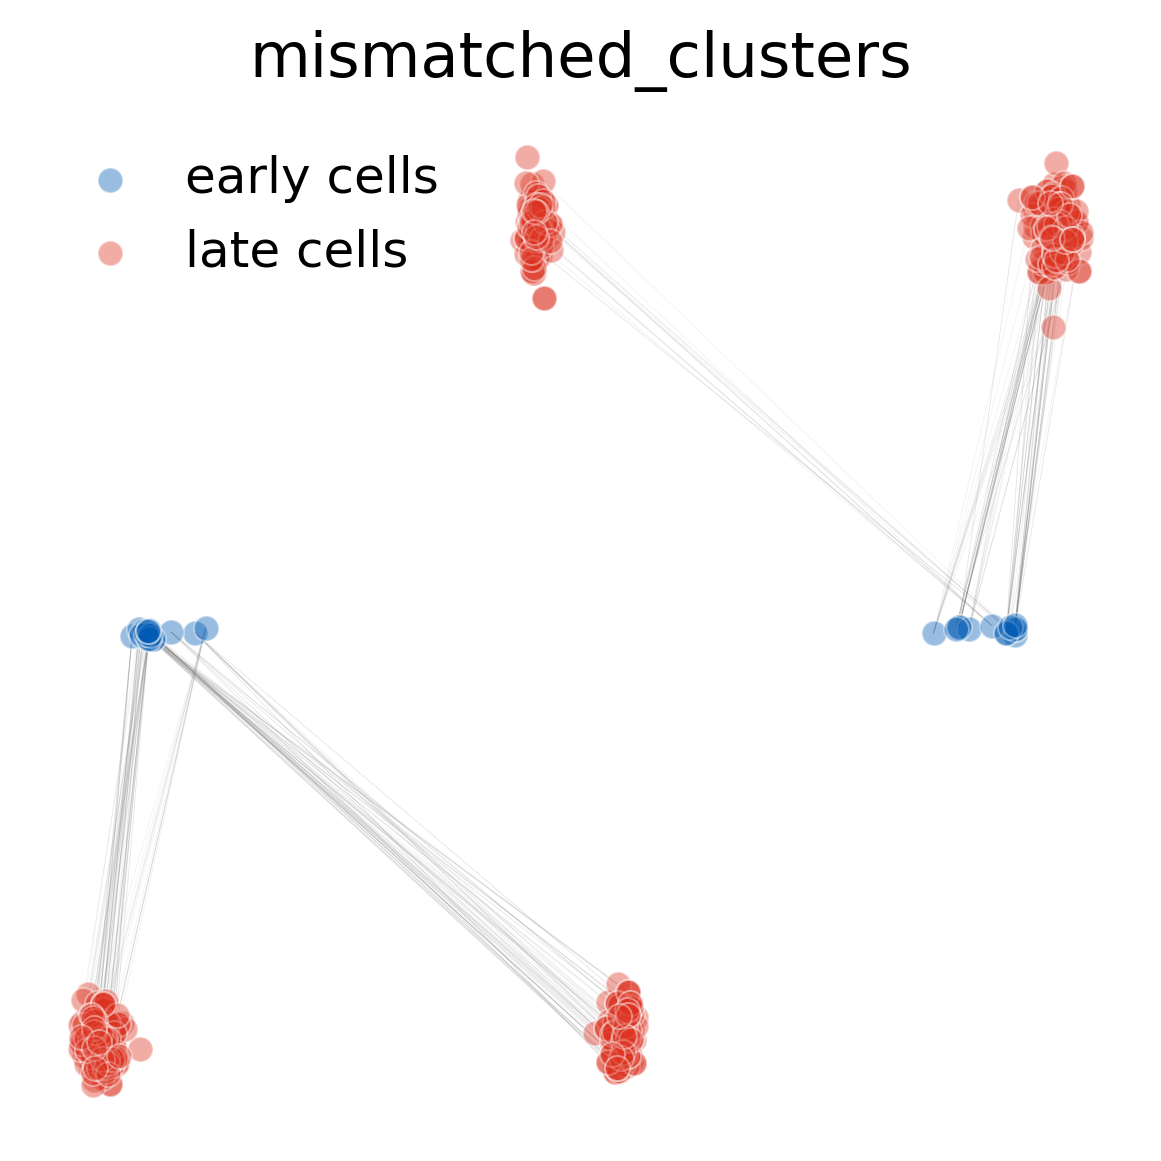

In [5]:
seed = 4698

for flow_type in flow_types:
    sim = simulate_data(flow_type, seed=seed)
    s, t = plot_trajectory(
        sim,
        flow_type=flow_type,
        savefig=save,
        subsample=True,
        alpha_scale=0.1,
        linewidth=0.2,
        legend_off=False,
    )

# Import simulation results

In [6]:
dfs = {}
for flow_type in flow_types:
    print(f"importing results of {flow_type}.")
    dfs[flow_type] = pd.read_csv(DATA_DIR / f"{flow_type}_res_seeds.csv")

importing results of bifurcation.
importing results of convergent.
importing results of partial_convergent.
importing results of mismatched_clusters.


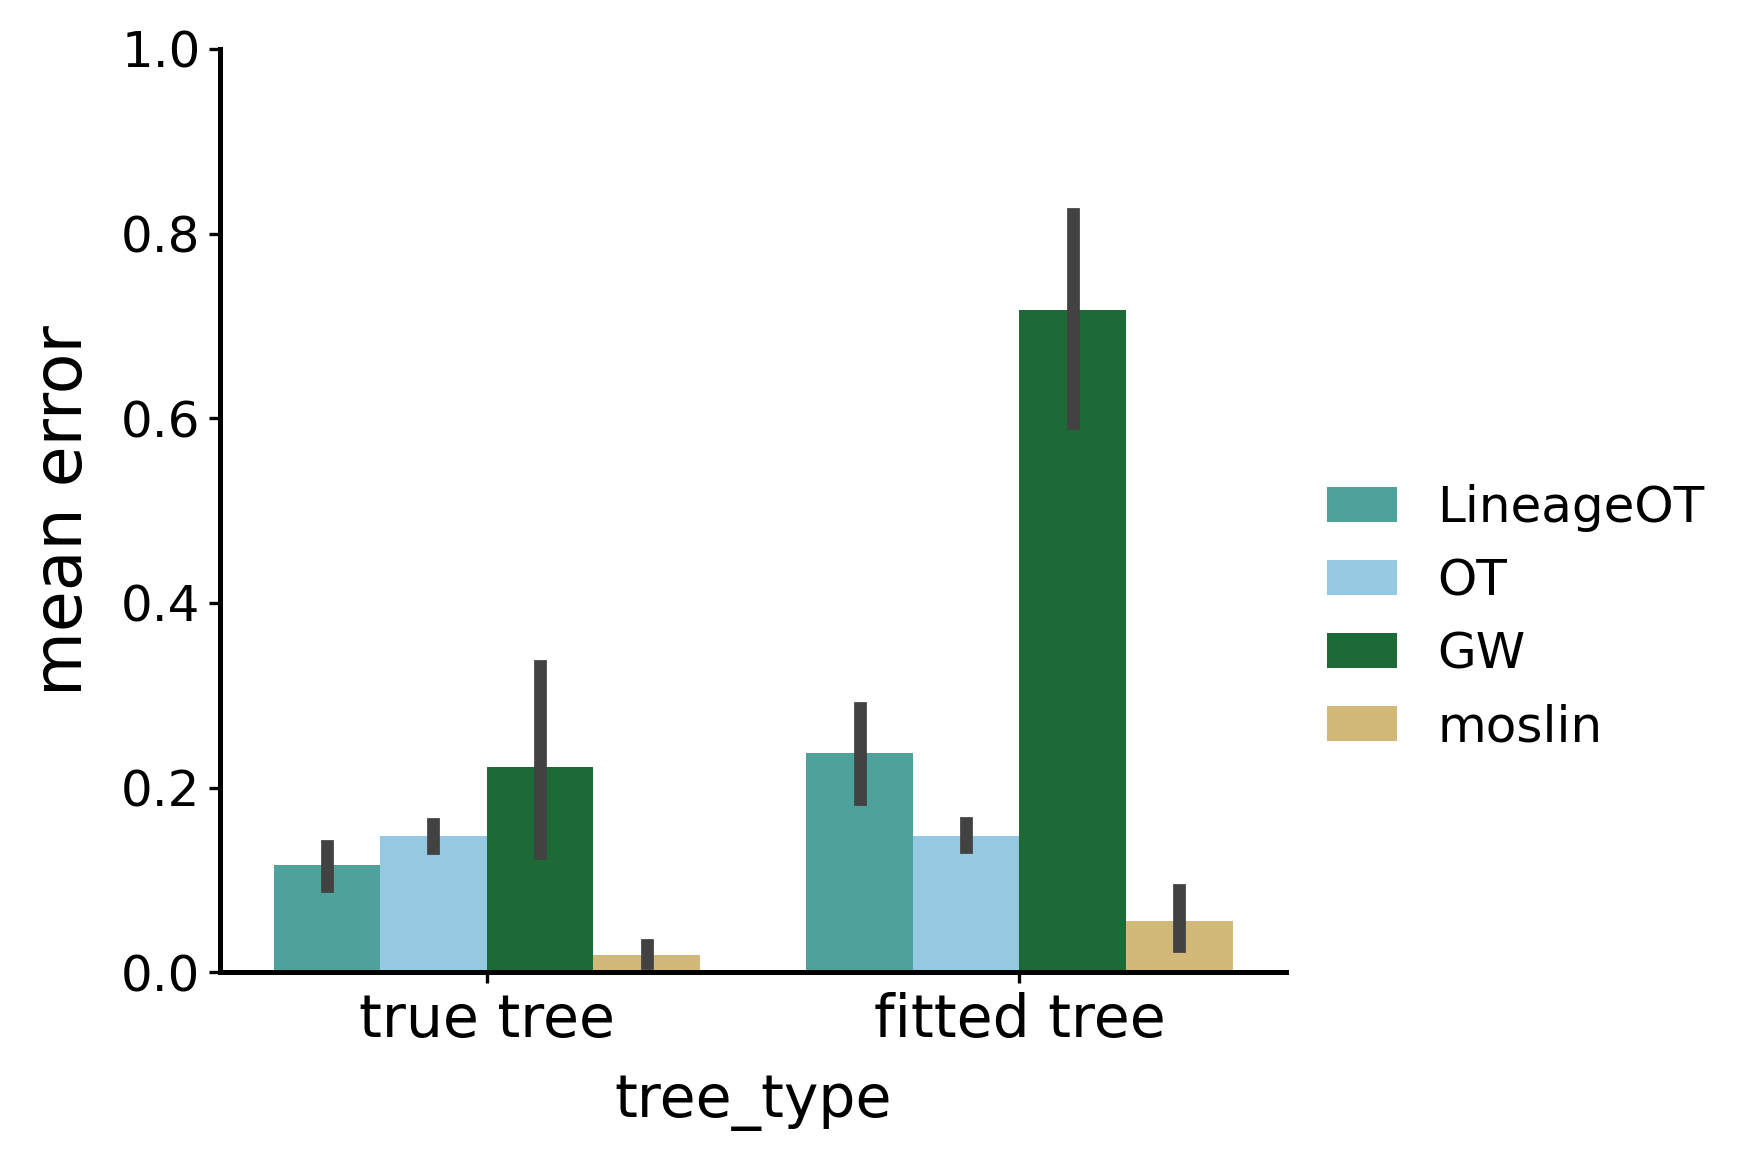

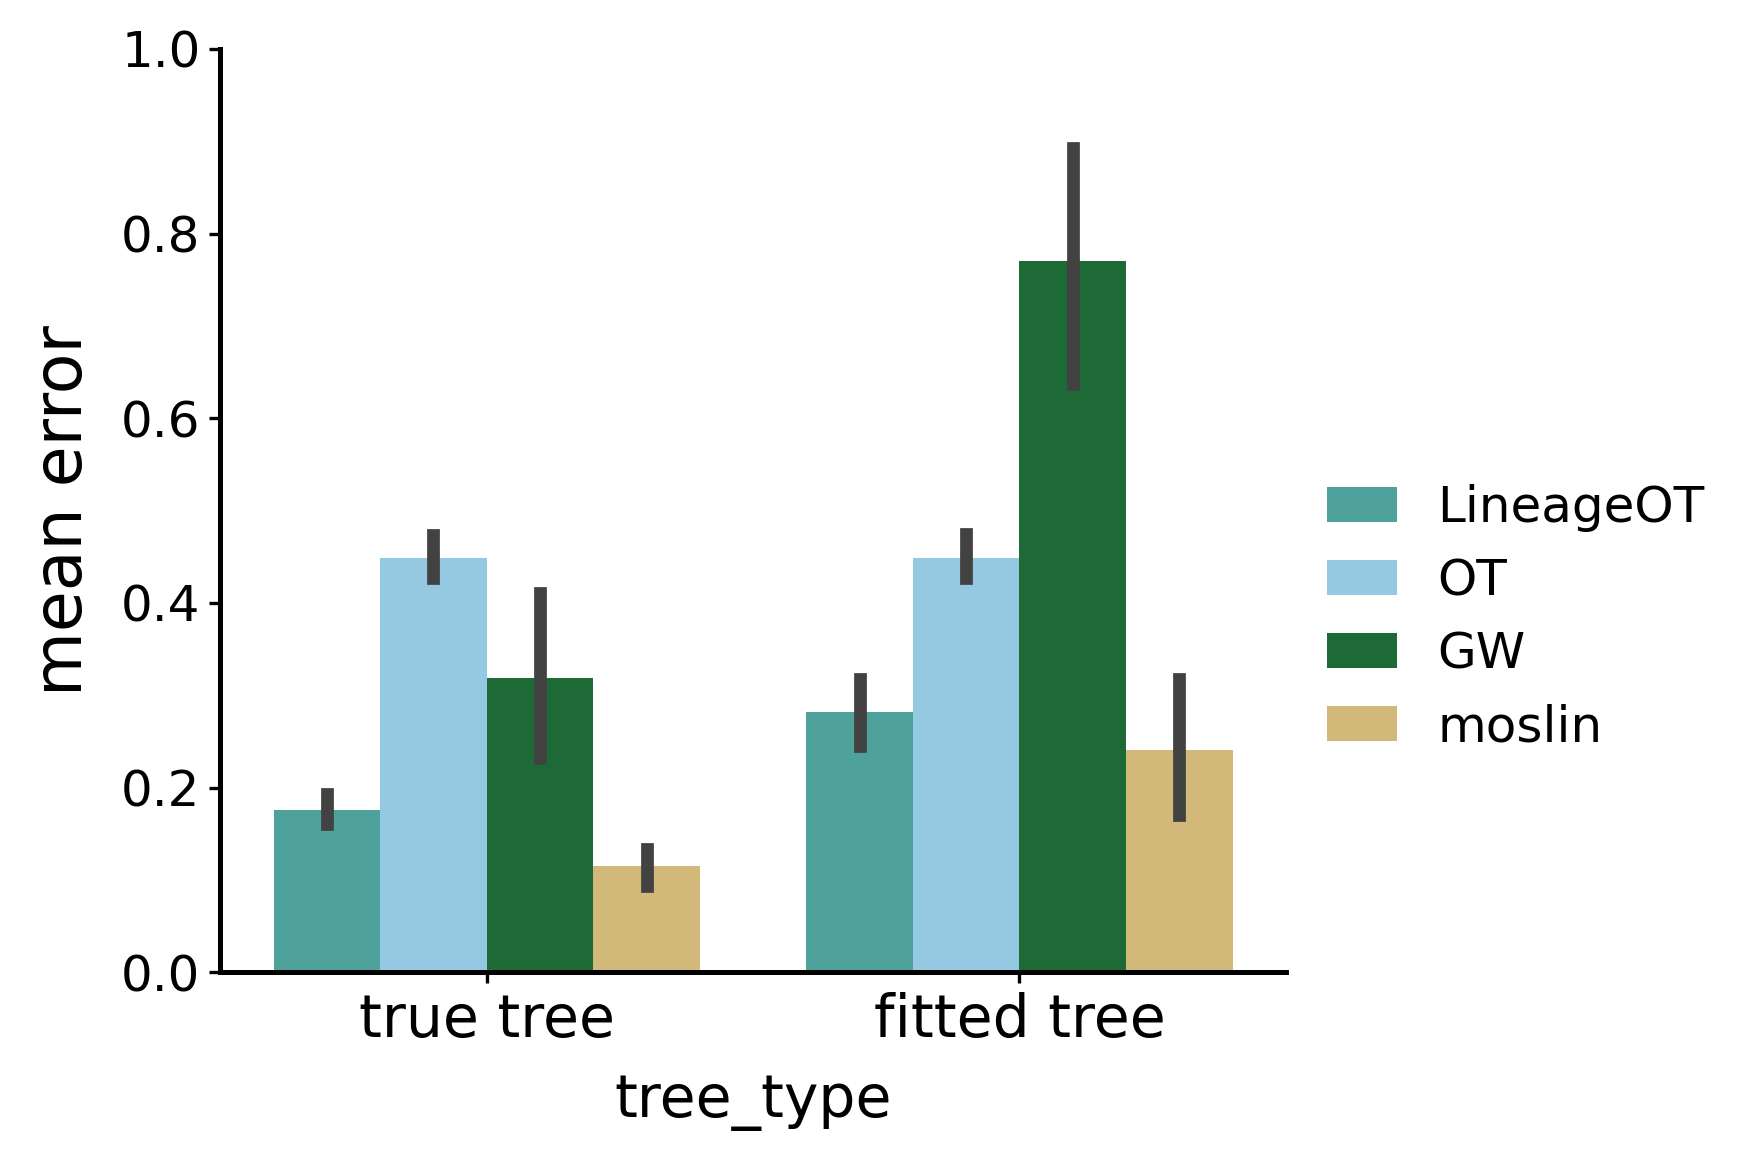

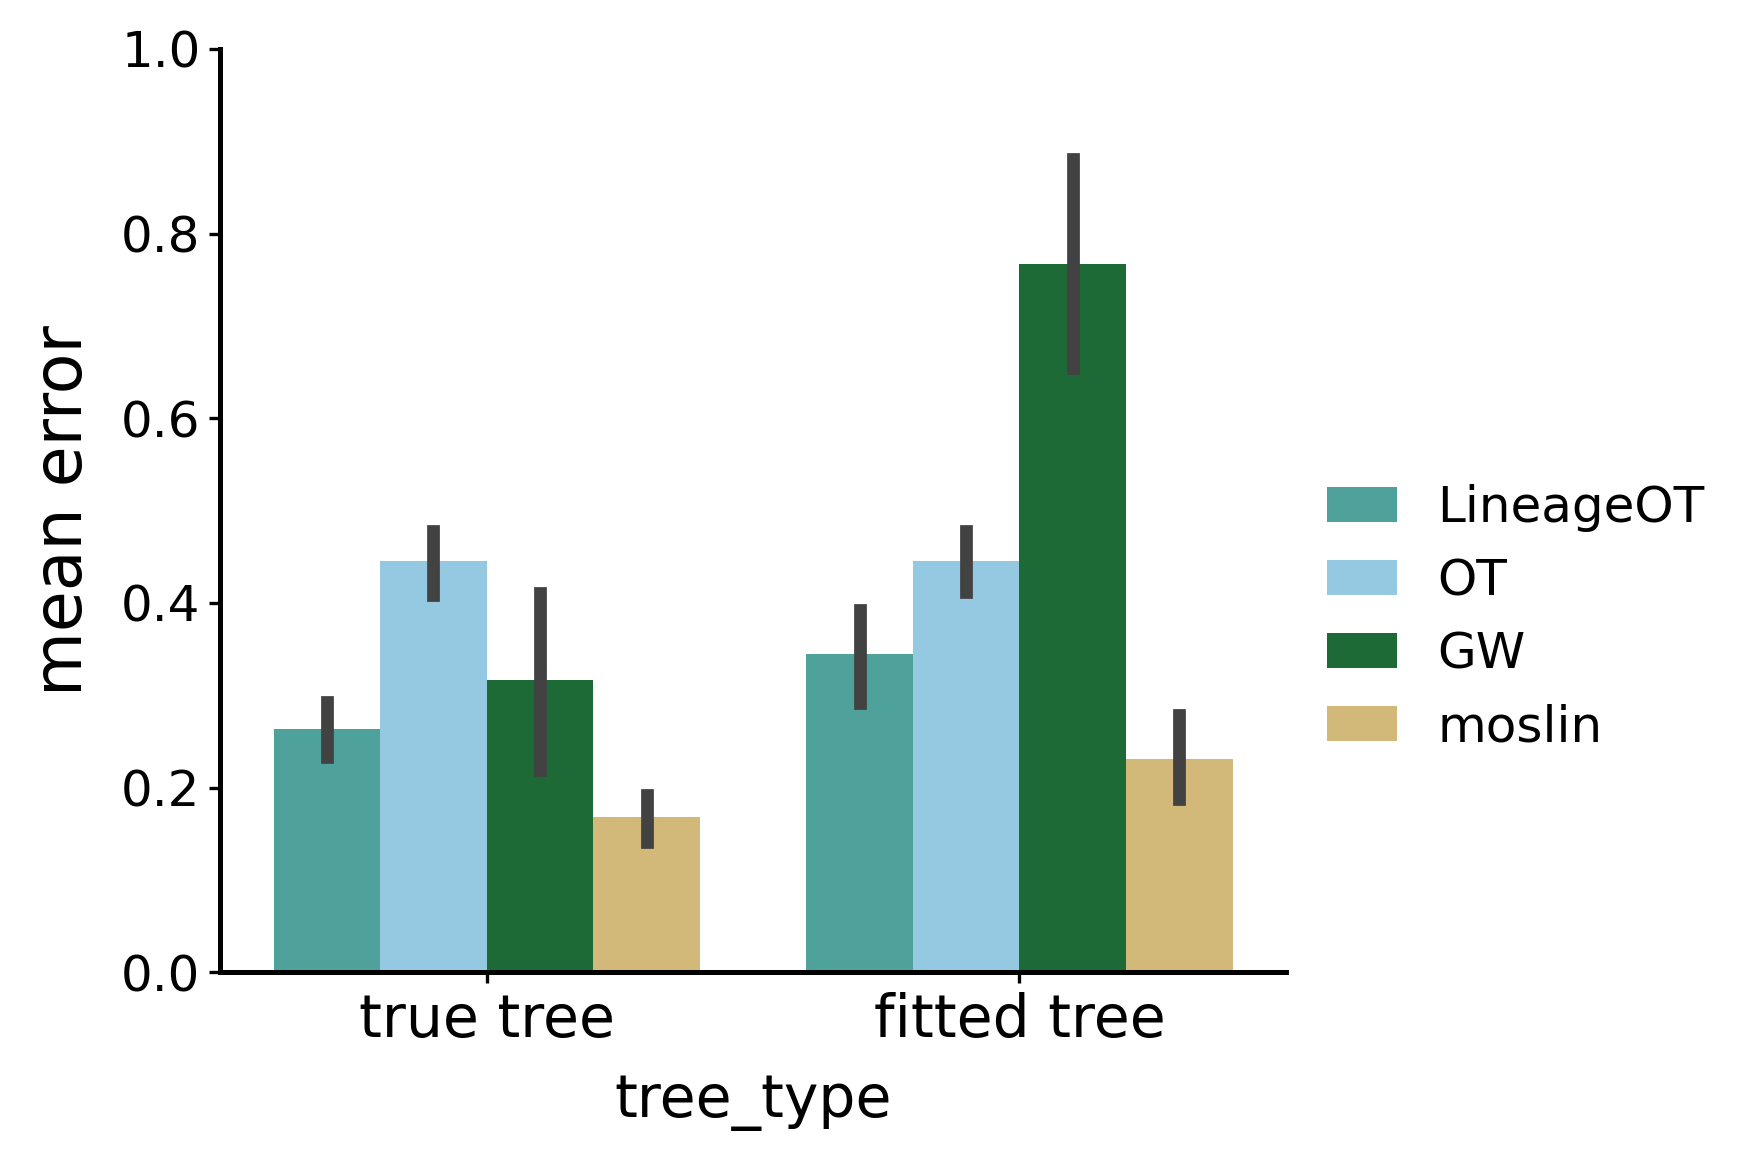

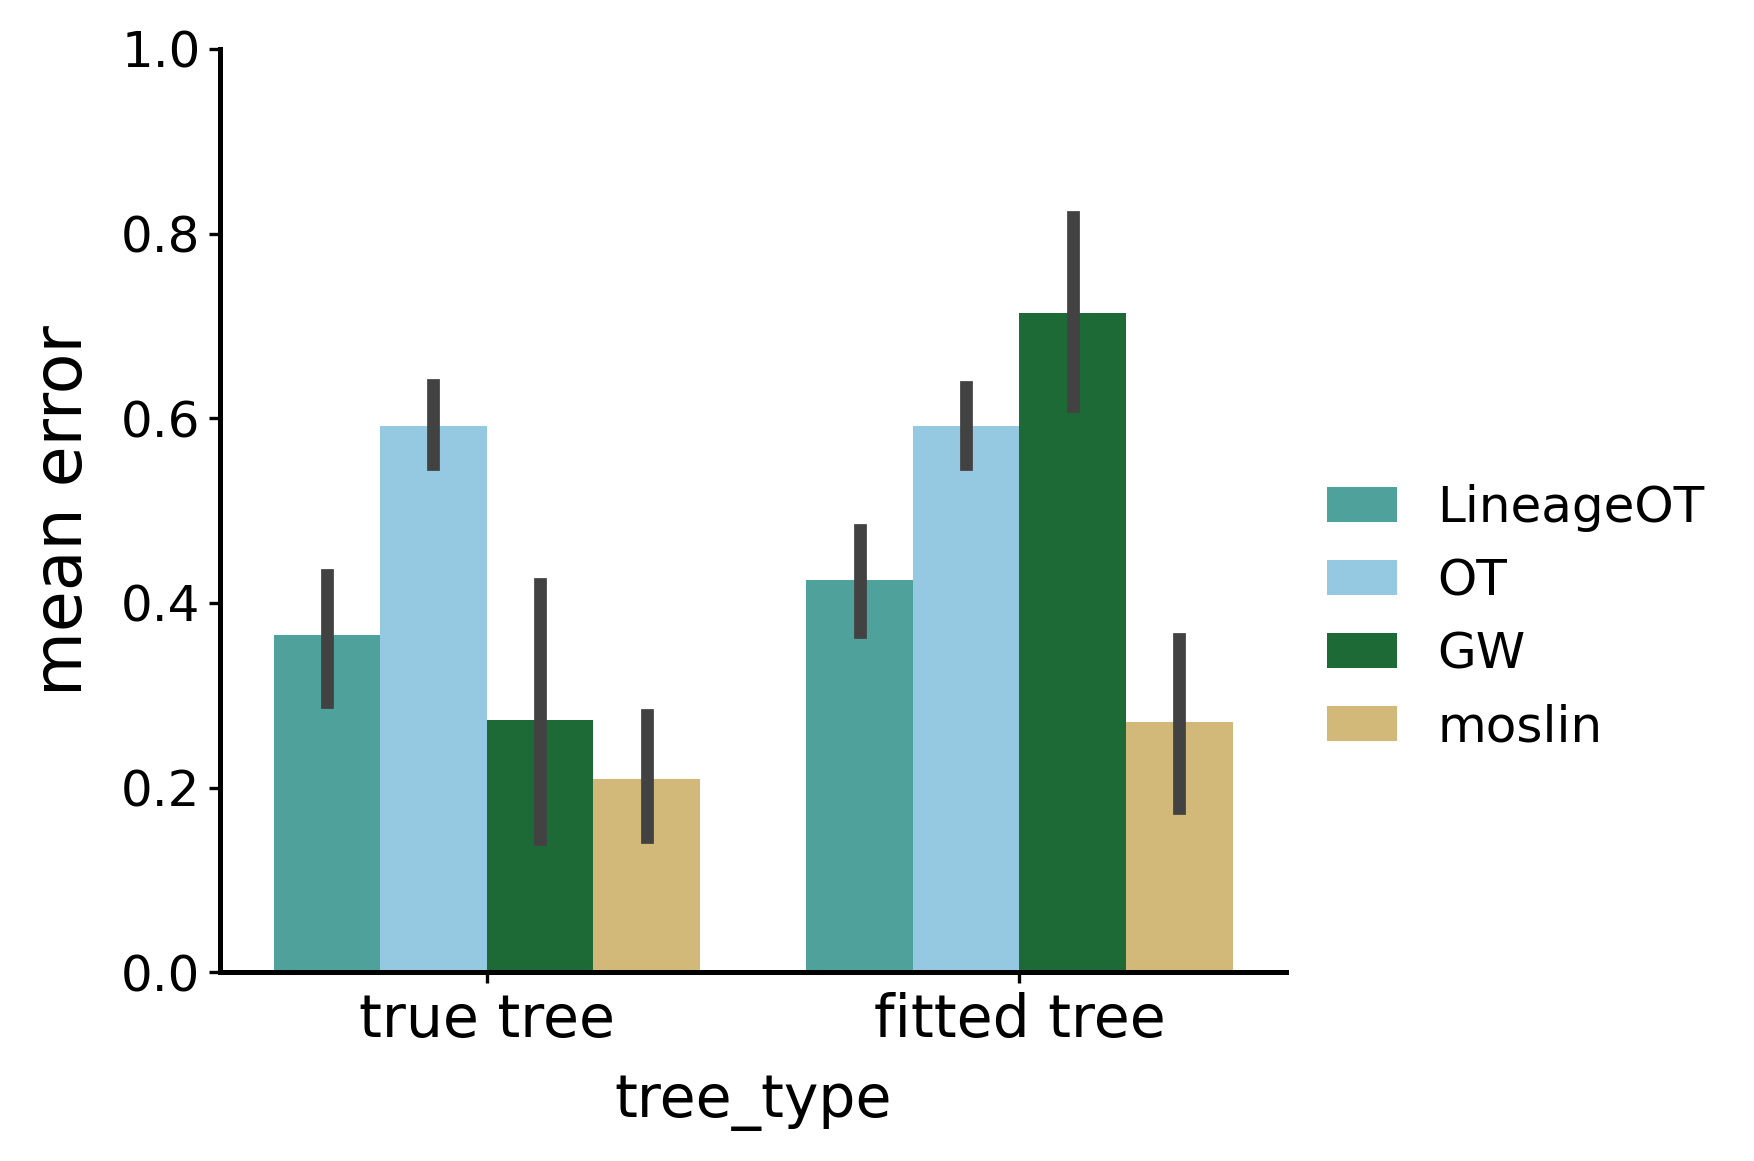

In [11]:
methods = ["LineageOT", "OT", "GW", "moslin"]

for flow_type, df in dfs.items():
    fig, axs = plt.subplots(1, 1, figsize=(6, 4))
    sns.barplot(
        data=df,
        x="tree_type",
        y="mean_error",
        hue="method",
        palette=method_colors,
        ax=axs,
    )
    axs.set_xticklabels(["true tree", "fitted tree"], fontsize=14)
    axs.set_ylabel("mean error", fontsize=16)
    axs.set_ylim(0, 1)
    plt.legend(bbox_to_anchor=(1.02, 0.55), loc="upper left", borderaxespad=0)
    plt.tight_layout()
    if save:
        plt.savefig(
            FIG_DIR / f"{flow_type}_bar.png",
            bbox_inches="tight",
            transparent=True,
            dpi=300,
        )
    plt.show()

In [8]:
dfm = {}
diffs_true = []
diffs_fitted = []
for flow_type, df in dfs.items():
    dfm[flow_type] = (
        df.groupby(["method", "tree_type"]).mean(["mean_error"]).reset_index()
    )
    val_lineageot = dfm[flow_type][dfm[flow_type]["method"] == "LineageOT"][
        "mean_error"
    ]
    val_moslin = dfm[flow_type][dfm[flow_type]["method"] == "moslin"]["mean_error"]
    diff = val_lineageot.values - val_moslin.values
    diffs_fitted.append(diff[0])
    diffs_true.append(diff[1])
    print(f"for {flow_type}:")
    print("lineageOT")
    print(val_lineageot.values)
    print("moslin")
    print(val_moslin.values)
    print("diff")
    print(val_lineageot.values - val_moslin.values)

for bifurcation:
lineageOT
[0.23730316 0.11583587]
moslin
[0.05528364 0.0191799 ]
diff
[0.18201951 0.09665597]
for convergent:
lineageOT
[0.2823862  0.17614619]
moslin
[0.24027659 0.11466664]
diff
[0.04210961 0.06147955]
for partial_convergent:
lineageOT
[0.34458883 0.26373505]
moslin
[0.23089064 0.16831287]
diff
[0.11369819 0.09542218]
for mismatched_clusters:
lineageOT
[0.42503606 0.36472465]
moslin
[0.27091559 0.20876689]
diff
[0.15412047 0.15595776]


In [9]:
np.mean(diffs_fitted)

0.12298694578571041

In [10]:
np.mean(diffs_true)

0.10237886559503552

# References

[[FS-21] Forrow, A., & Schiebinger, G. LineageOT is a unified framework for lineage tracing and trajectory inference. Nature communications, 12(1), 4940.](https://www.nature.com/articles/s41467-021-25133-1)